In [454]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import imblearn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from imblearn.over_sampling import SMOTE

In [455]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data exploration

| Variable | Definition | Key |
| --- | --- | --- |
| Survival | Did the person survive? | 0 = No, 1 = Yes|
| Pclass | Ticket class | 1 = 1st Class, 2 = Middle Class, 3 = Lower Class |
| Sex | Gender of the person | Male or Female |
| Sibsp | Number of sibling / spouses on Titanic | Numeric |
| Parch | Number of parents / children on Titanic | Numeric |
| Ticket | Ticket number | Alpha-numeric |
| Fare | Ticket fare | Numeric |
| Cabin | Cabin number | Alpha-numeric |
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [456]:
train.head()
# Columns "PassengerId" and "Ticket" are columns that might be unique identifiers. Makes good sense to drop them.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [457]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [458]:
train.info()

#From here we can see that Cabin has very little information. I think I will drop it right away.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [459]:
train = train.drop(columns=['Cabin','PassengerId','Ticket'])

In [460]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [461]:
# Seems as though it isn't really possible to compute age for these people.
# One approach is that we can just drop the NaN ages as it seems that ages are important.
# Or we can fill up the NaN ages by the median of other catagories

train[train['Age'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
5,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,Q
17,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,13.0000,S
19,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,7.2250,C
26,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,7.2250,C
28,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,7.8792,Q
...,...,...,...,...,...,...,...,...,...
859,0,3,"Razi, Mr. Raihed",male,NaN,0,0,7.2292,C
863,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,69.5500,S
868,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,9.5000,S
878,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,7.8958,S


## Branching: Dataset by dropping age with NaN

In [462]:
ageclean_train = train.dropna(subset=['Age'])

In [463]:
ageclean_train.shape

# We now have 714 rows.
# Is the NaN embarked there as well?

(714, 9)

In [464]:
ageclean_train[ageclean_train['Embarked'].isna()]

#Yes, oh well. I'll drop 2 more columns here

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


In [465]:
ageemclean_train = ageclean_train.dropna(subset=['Embarked']) #Dropped the rows with NA for Embarked

In [466]:
ageemclean_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
885,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,29.1250,Q
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C


In [467]:
#Now let me get the designations of each person out as a new variable, and put it back into the training data

Namelist = list(ageemclean_train.Name.str.split(","))
namedes = []
for n in Namelist:
    namedes.append(n[1])
for i in range(len(namedes)):
    des = namedes[i]
    dessplit = des.split(" ")
    if dessplit[1] != 'the':
        designation = dessplit[1].replace(".","")
    else:
        designation = dessplit[2].replace(".","")
    namedes[i] = designation
    
ageemclean_train['Designation'] = np.array(namedes)
ageemclean_train.drop(columns='Name',inplace=True)

/Users/jzpee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/jzpee/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [468]:
# Lets do some data visualization now.
# The dependent variable is Survived

# The independent variables that we are working with are:
# Pclass, Sex, Age, Sibsp, Parch, Fare, Embarked, Designation
# Catagorical variables are: Pclass, Designation, Sex, SibSp, Parch
# Numerical variables are : Age, Fare
# For the numerical variable age, we might bin them into groups, after looking at the distribution.

In [469]:
ageemclean_train.shape # Shape for this dataframe

(712, 9)

In [470]:
ageemclean_train.groupby("Survived")['Pclass'].count() 
# There are 424 non-survivors and 290 survivors.
# There is 47.2% more non survivors than survivors.
# We can probably SMOTE the survivors later on to have a balanced dataset

Survived
0    424
1    288
Name: Pclass, dtype: int64

In [471]:
# Pclass
ageemclean_train.groupby(['Pclass','Survived'])['SibSp'].count() 
#Looks like a large number of people in the Upper class survived (comparison in terms of proportion survived)
# ~50% upper , 25% in middle and lower

Pclass  Survived
1       0            64
        1           120
2       0            90
        1            83
3       0           270
        1            85
Name: SibSp, dtype: int64

In [472]:
#SibSp

ageemclean_train.groupby(['SibSp','Survived'])['Pclass'].count()

# The classes of 2 , 3 , 4 have very little people. Might be useful if we can group them together
# 0 Being no sibling / spouses on the ship, 1 otherwise

SibSp  Survived
0      0           296
       1           173
1      0            86
       1            97
2      0            14
       1            11
3      0             8
       1             4
4      0            15
       1             3
5      0             5
Name: Pclass, dtype: int64

In [473]:
#Parch

ageemclean_train.groupby(['Parch','Survived'])['Pclass'].count()

# The classes of 2, 3, 4, 5, 6 have very little people. Might be useful if we can regroup them as 0 or 1
# 0 Being no parents or children on the same ship, 1 being otherwise

Parch  Survived
0      0           335
       1           184
1      0            49
       1            61
2      0            29
       1            39
3      0             2
       1             3
4      0             4
5      0             4
       1             1
6      0             1
Name: Pclass, dtype: int64

In [474]:
#Sex

ageemclean_train.groupby(['Sex','Survived'])['Pclass'].count()

#A lot more males died than females.

Sex     Survived
female  0            64
        1           195
male    0           360
        1            93
Name: Pclass, dtype: int64

ANOVA for Fare and Pclass, P-value is: 1.821885989198717e-69
This means that Fare and Pclass are correlated, might be sufficient to keep either one


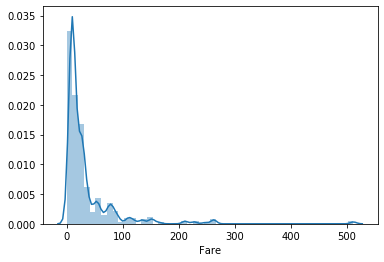

In [475]:
#Fare 

sns.distplot(ageemclean_train.Fare)

model = ols('Fare' +' ~ C(Pclass)', data=ageemclean_train).fit()
pval = sm.stats.anova_lm(model).iloc[0,4]
print("ANOVA for Fare and Pclass, P-value is:", pval)
print("This means that Fare and Pclass are correlated, might be sufficient to keep either one")

In [476]:
#Embarked

ageemclean_train.groupby(['Embarked','Survived'])['Pclass'].count()

#Proportion of people embarking at C and Q is rather small, most of the people embarked at S.

Embarked  Survived
C         0            51
          1            79
Q         0            20
          1             8
S         0           353
          1           201
Name: Pclass, dtype: int64

In [477]:
#Designation

ageemclean_train.groupby(['Designation','Survived'])['Pclass'].count()

#Proportion of people embarking at C and Q is rather small, most of the people embarked at S.

Designation  Survived
Capt         0             1
Col          0             1
             1             1
Countess     1             1
Don          0             1
Dr           0             3
             1             3
Jonkheer     0             1
Lady         1             1
Major        0             1
             1             1
Master       0            15
             1            21
Miss         0            41
             1           104
Mlle         1             2
Mme          1             1
Mr           0           331
             1            67
Mrs          0            23
             1            84
Ms           1             1
Rev          0             6
Sir          1             1
Name: Pclass, dtype: int64

**Integer Encoding vs One hot encoding**

1. Integer Encoding


As a first step, each unique category value is assigned an integer value.

For example, “red” is 1, “green” is 2, and “blue” is 3.

This is called a label encoding or an integer encoding and is easily reversible.

For some variables, this may be enough.

The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship.

For example, ordinal variables like the “place” example above would be a good example where a label encoding would be sufficient.

2. One-Hot Encoding


For categorical variables where no such ordinal relationship exists, the integer encoding is not enough.

In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [478]:
train_dropna = pd.get_dummies(ageemclean_train)

In [479]:
train_dropna.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Designation_Capt', 'Designation_Col', 'Designation_Countess',
       'Designation_Don', 'Designation_Dr', 'Designation_Jonkheer',
       'Designation_Lady', 'Designation_Major', 'Designation_Master',
       'Designation_Miss', 'Designation_Mlle', 'Designation_Mme',
       'Designation_Mr', 'Designation_Mrs', 'Designation_Ms',
       'Designation_Rev', 'Designation_Sir'],
      dtype='object')

In [480]:
q1 = np.quantile(train_dropna.Age,0.333)
q2 = np.quantile(train_dropna.Age,0.666)
agelist = list(train_dropna.Age)
agecat = []
for i in range(len(agelist)):
    age = agelist[i]
    if age < q1:
        agecat.append(1)
    elif age < q2:
        agecat.append(2)
    else:
        agecat.append(3)
        
train_dropna['Agecat'] =  agecat
train_dropna.drop(columns='Age',inplace=True)

In [481]:
sibsp = list(train_dropna.SibSp)
Parch = list(train_dropna.Parch)

In [482]:
for i in range(len(sibsp)):
    if sibsp[i] != 0:
        sibsp[i] = 1
    if Parch[i] != 0:
        Parch[i] = 1

In [483]:
train_dropna['sibsp_yn'] = sibsp
train_dropna['parch_yn'] = Parch
train_dropna.drop(columns=['SibSp','Parch'],inplace=True)

In [484]:
train_dropna.columns

Index(['Survived', 'Pclass', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Designation_Capt', 'Designation_Col',
       'Designation_Countess', 'Designation_Don', 'Designation_Dr',
       'Designation_Jonkheer', 'Designation_Lady', 'Designation_Major',
       'Designation_Master', 'Designation_Miss', 'Designation_Mlle',
       'Designation_Mme', 'Designation_Mr', 'Designation_Mrs',
       'Designation_Ms', 'Designation_Rev', 'Designation_Sir', 'Agecat',
       'sibsp_yn', 'parch_yn'],
      dtype='object')

In [485]:
X_train_dropna = train_dropna.drop(columns=['Survived'])
y_train_dropna = train_dropna.Survived

In [486]:
print("Number of variables for training dataset:", X_train_dropna.shape[1])
print(X_train_dropna.columns)
train_new = X_train_dropna.copy()
train_new["Y"] = y_train_dropna
X_train_dropna

Number of variables for training dataset: 27
Index(['Pclass', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Designation_Capt', 'Designation_Col',
       'Designation_Countess', 'Designation_Don', 'Designation_Dr',
       'Designation_Jonkheer', 'Designation_Lady', 'Designation_Major',
       'Designation_Master', 'Designation_Miss', 'Designation_Mlle',
       'Designation_Mme', 'Designation_Mr', 'Designation_Mrs',
       'Designation_Ms', 'Designation_Rev', 'Designation_Sir', 'Agecat',
       'sibsp_yn', 'parch_yn'],
      dtype='object')


,Pclass,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Designation_Capt,Designation_Col,Designation_Countess,...,Designation_Mlle,Designation_Mme,Designation_Mr,Designation_Mrs,Designation_Ms,Designation_Rev,Designation_Sir,Agecat,sibsp_yn,parch_yn
0,3,7.2500,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,1,0
1,1,71.2833,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,3,1,0
2,3,7.9250,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,0,0
3,1,53.1000,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,0
4,3,8.0500,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,3,29.1250,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,3,0,1
886,2,13.0000,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,2,0,0
887,1,30.0000,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
889,1,30.0000,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,2,0,0


# Balancing the dataset with SMOTE

In [487]:
X_train, X_val, y_train, y_val = train_test_split(X_train_dropna, y_train_dropna, test_size=0.3, random_state=0)
columns = X_train.columns
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [488]:
fullsm = X_sm.copy()
fullsm['Y'] = y_sm

# Logistic Regression

In [446]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 500)
logreg.fit(X_sm, y_sm)
Y_pred = logreg.predict(X_val)
acc_log = round(logreg.score(X_sm, y_sm) * 100, 2)
print(acc_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_val, y_val)))

82.44
Accuracy of logistic regression classifier on test set: 0.78


In [598]:
test = pd.read_csv('test.csv')

In [599]:
# Format my test dataset the same as I did for the train

test = test.drop(columns=['PassengerId','Cabin','Ticket'])

In [600]:
#Now let me get the designations of each person out as a new variable, and put it back into the training data

Namelisttest = list(test.Name.str.split(","))
namedestest = []
for n in Namelisttest:
    namedestest.append(n[1])
for i in range(len(namedestest)):
    destest = namedestest[i]
    dessplittest = destest.split(" ")
    if dessplittest[1] != 'the':
        designationtest = dessplittest[1].replace(".","")
    else:
        designationtest = dessplittest[2].replace(".","")
    namedestest[i] = designationtest
    
test['Designation'] = np.array(namedestest)
test.drop(columns='Name',inplace=True)

In [601]:
q1test = np.quantile(test.Age,0.333)
q2test = np.quantile(test.Age,0.666)
agelisttest = list(test.Age)
agecattest = []
for i in range(len(agelisttest)):
    agetest = agelisttest[i]
    if agetest < q1test:
        agecattest.append(1)
    elif agetest < q2test:
        agecattest.append(2)
    else:
        agecattest.append(3)
        
test['Agecat'] =  agecattest
test.drop(columns='Age',inplace=True)

In [602]:
sibsptest = list(test.SibSp)
Parchtest = list(test.Parch)

In [603]:
for i in range(len(sibsptest)):
    if sibsptest[i] != 0:
        sibsptest[i] = 1
    if Parchtest[i] != 0:
        Parchtest[i] = 1

In [604]:
test['sibsp_yn'] = sibsptest
test['parch_yn'] = Parchtest
test.drop(columns=['SibSp','Parch'],inplace=True)

In [605]:
testset = pd.get_dummies(test)

In [606]:
testset.columns

Index(['Pclass', 'Fare', 'Agecat', 'sibsp_yn', 'parch_yn', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Designation_Col',
       'Designation_Dona', 'Designation_Dr', 'Designation_Master',
       'Designation_Miss', 'Designation_Mr', 'Designation_Mrs',
       'Designation_Ms', 'Designation_Rev'],
      dtype='object')

In [607]:
testset.drop(columns='Designation_Dona',inplace=True)

In [608]:
zeroes = []
for i in range(418):
    zeroes.append(0)

In [609]:
traincols = list(X_train.columns)
testcols = list(testset.columns)

In [610]:
notthere =[]
for i in traincols:
    if i not in testcols:
        notthere.append(i)

In [611]:
for x in notthere:
    testset[x] = zeroes

In [612]:
X_train.shape

(498, 27)

In [614]:
testset = testset.fillna(testset.mean())

In [615]:
Y_test = logreg.predict(testset)

In [617]:
len(Y_test)

418

In [ ]:
gender_sub = 

In [624]:
testref = pd.read_csv('test.csv')

In [625]:
testref = testref['PassengerId']

In [627]:
testref = pd.DataFrame(testref)

In [629]:
testref['Survived'] = Y_test

In [630]:
testref

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,1
415,1307,1
416,1308,1


In [632]:
testref.to_csv('result.csv',index=False)